<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - SH openEO backend data fusion use case
### Calculate mean NDVI of data fusion of 2 collections over time (as synchronous and batch job) and export the result (locally, via signed URL)

In [1]:
import openeo
import rioxarray

**1. Open the connect to openEO Platform (development backend) and authenticate**  
- establish connection to the openEO Platform back-end
- connection object is your central gateway to load data

In [2]:
from openeo.rest.auth.config import RefreshTokenStore
RefreshTokenStore().remove()

In [3]:
# Connect to openEO Platform back-end (https://openeo.cloud) which has the SH production backend implemented
connection = openeo.connect("https://openeo.cloud")

# Authenticate via EGI
connection.authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=WTMK-GBGV 📋 to authenticate.

[##############################-------] Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

**2. Define spatial and temporal extent, bands and specify backend to be used for 2 collections**

In [4]:
# Load data cube from Sentinel2_L2A collection for a 3-weeks cloud free priod in July 2021 north of Ljubljana
# (5 aquisitions)
cube_l2a = connection.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent={"west": 14.583040689005495, "south": 46.10348118219517, "east": 14.599965321685639, 
                    "north": 46.11226598409823},
    temporal_extent=["2021-07-09", "2022-07-30"],
    bands=["B01", "B04"]
)

# Load data cube from Sentinel2_L1C collection for a 3-weeks cloud free priod in July 2021 north of Ljubljana
# (5 aquisitions)
cube_l1c = connection.load_collection(
    "SENTINEL2_L1C_SENTINELHUB",
    spatial_extent={"west": 14.583040689005495, "south": 46.10348118219517, "east": 14.599965321685639, 
                    "north": 46.11226598409823},
    temporal_extent=["2021-07-09", "2022-07-30"],
    bands=["B02", "B08"],
    properties={"provider:backend":lambda v: v =="sentinelhub"}
)

**3. Merge the datacubes together into a single datacube**

In [5]:
merged_cube = cube_l2a.merge_cubes(cube_l1c)

**4. Calculate the mean over the temporal extent and afterward calculate the NDVI**

In [6]:
# Calculate mean of B04 and B08
merged_cube_mean = merged_cube.reduce_dimension(dimension="t", reducer="mean")

In [7]:
# Calculate NDVI
merged_cube_mean_ndvi_all_bands = merged_cube_mean.ndvi(nir = "B08", red = "B04", target_band = "NDVI")

In [8]:
# Filter bands
merged_cube_mean_ndvi = merged_cube_mean_ndvi_all_bands.filter_bands(["NDVI"])

## Synchronous processing
**5. Download data synchronously**

In [25]:
# depending on the backend load this synchronous call sometimes times out
# as the result is part of the repository you can continue with the next cell 
# and visualize the result and run the job as batch job
merged_cube_mean_ndvi.download("merged_cube_mean_ndvi.tiff")

**6. Plot NDVI data on map**

In [26]:
# Open into an xarray.DataArray
geotiff_da = rioxarray.open_rasterio("./merged_cube_mean_ndvi.tiff")

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band').rename({1: 'NDVI'})

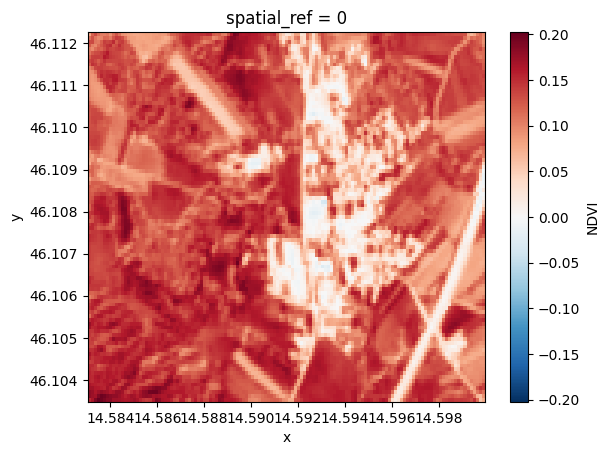

In [27]:
# plot mean NDVI data on map
geotiff_ds.NDVI.plot()

## Batch processing
**5. Save results as Geotiff**

In [15]:
# Save results
merged_cube_mean_ndvi_tiff = merged_cube_mean_ndvi.save_result(format="GTiff")

**6. Create a batch job and start it.**

More info about batch jobs can be found here:

- https://openeo.org/documentation/1.0/glossary.html#data-processing-modes

- https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [16]:
# create the job 
job = merged_cube_mean_ndvi_tiff.create_job(title = 'Data_Fusion_Mean_NDVI_Ljubljana_demo')

# save job id and print it
job_id = job.job_id
print("Batch job created with id: ",job_id)

Batch job created with id:  sentinelhub-8eab8525-5e37-4901-a0ab-296b55c24191


In [17]:
# start the job
job.start_job() 

In [35]:
# output batch job status 
print("Batch job with id: ",job_id, ' is ',job.status())

Batch job with id:  sentinelhub-8eab8525-5e37-4901-a0ab-296b55c24191  is  finished


**7. When batch job status is `finished`, get job metadata via signed URL**

In [36]:
# get job metadata to get signed URL from Assets
job = connection.job(job_id)
job.get_results()

<JobResults for job 'sentinelhub-8eab8525-5e37-4901-a0ab-296b55c24191'>